# Importing essential Python libraries

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
matplotlib.style.use('ggplot')

## 1. Loading data and exploratory analysis

In [2]:
sdata_andes = pd.read_csv('andes.csv')# load the spectra
sdata_coast = pd.read_csv('coastI.csv')
rawspectra = sdata_andes.append(sdata_coast) # crate a unique dataset (DataFrame)
rawspectra.index = range(70) # indexing the rows from 0 to 69

carbon_data = pd.read_csv('C_and_description.csv') # load the dataset
print('VNIR DataFrame shape:', carbon_data.shape)

VNIR DataFrame shape: (70, 5)


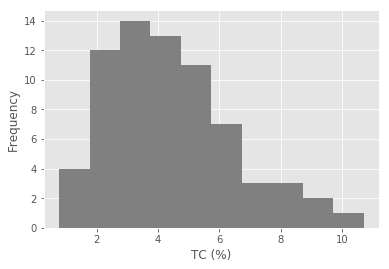

In [3]:
ax = carbon_data.C.hist(color='gray');
ax.set_xlabel('TC (%)');
ax.set_ylabel('Frequency');

In [4]:
print(carbon_data.groupby(['location', 'depth']).mean().C)

location  depth  
Andes     (0-5)      6.453333
          (20-40)    3.051667
          (5-20)     4.366667
Coast     (0-5)      5.311667
          (20-40)    2.717273
          (5-20)     4.502727
Name: C, dtype: float64


## 2. Pre-processing

### 2.1 Defining functions

In [5]:
def sgfilter(data, ws, pol, d=0):
    
    """
    Function for filtering spectral data and convert it into Pandas DataFrame
    
    Arguments:
        data = spectral dataframe
        ws = window size
        pol = polynomial order
        d = derivative order
    
    """
    
    from scipy.signal import savgol_filter
    
    spdataf = savgol_filter(data, ws, 
                      pol, deriv=d, delta=1.0, axis=-1, mode='interp', cval=0.0)# result in numpy array
    spdataf = pd.DataFrame(spdataf) 
    spdataf.index = data.index
    spdataf.columns = data.columns
    
    return spdataf



def Ref_to_absorbance (reflectance):
    "Apply Log (1/R)"

    from numpy import log10
    
    return log10(1/reflectance)
    

### 2.2 Filtering data by Savitzky-Golay filter

In [6]:
filtered_spectra1  = sgfilter(rawspectra, 5, 1, 0)
filtered_spectra2  = sgfilter(rawspectra, 5, 2, 0)
filtered_spectra3  = sgfilter(rawspectra, 5, 1, 1)
filtered_spectra4  = sgfilter(rawspectra, 5, 2, 2)
filtered_spectra5  = sgfilter(rawspectra, 11, 1, 0)
filtered_spectra6  = sgfilter(rawspectra, 11, 2, 0)
filtered_spectra7  = sgfilter(rawspectra, 11, 1, 1)
filtered_spectra8  = sgfilter(rawspectra, 11, 2, 2)
filtered_spectra9  = sgfilter(rawspectra, 17, 1, 0)
filtered_spectra10 = sgfilter(rawspectra, 17, 2, 0)
filtered_spectra11 = sgfilter(rawspectra, 17, 1, 1)
filtered_spectra12 = sgfilter(rawspectra, 17, 2, 2)
filtered_spectra13 = sgfilter(rawspectra, 35, 1, 0)
filtered_spectra14 = sgfilter(rawspectra, 99, 1, 0)
log_spectra        = Ref_to_absorbance (filtered_spectra9)
centered_spectra   = filtered_spectra9.apply(lambda x: (x - np.mean(x)))

In [7]:
# select the data to use for next calculations
spectral_data = filtered_spectra9

### 2.3 Plotting some spectral curves
In the given list [2, 15, 23, 45, 56, 67], you can add any number from 0 to 67 separated by commas.

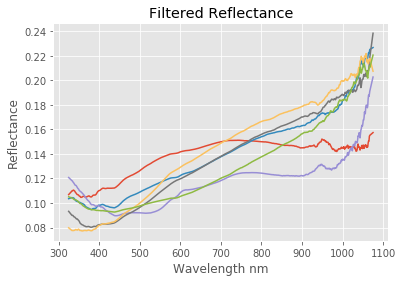

In [8]:
fig, ax = plt.subplots()

for i in [2, 15, 23, 45, 56, 67]:
    ax.plot(spectral_data.loc[i])
    
ax.set_xlabel('Wavelength nm')
ax.set_ylabel('Reflectance'); #change to Aparent Absorbance if the data in Log transformed
ax.set_title('Filtered Reflectance');

Next, we can create a new dataframe with the more clean range e.g. (400-924 nm).

### 2.4. Selecting the more clean spectral range and plotting again.

In [9]:
selected_spectra = spectral_data.ix[:, 75:600]
print('The shape of the new dataframe is:',selected_spectra.shape)

The shape of the new dataframe is: (70, 525)


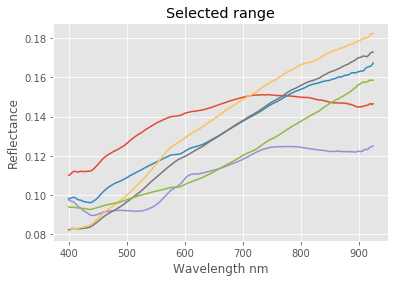

In [10]:
### plotting ###
fig, ax = plt.subplots()

for i in [2, 15, 23, 45, 56, 67]:
    ax.plot(selected_spectra.loc[i])
    
ax.set_xlabel('Wavelength nm')
ax.set_ylabel('Reflectance'); #change to Aparent Absorbance if the data in Log transformed
ax.set_title('Selected range');

## 3. PCA Analysis

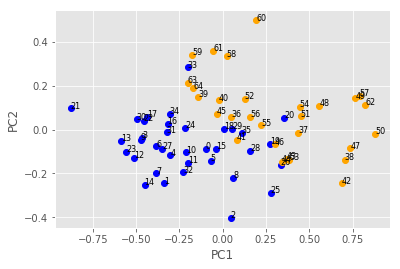

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)# set number of components

pc = pca.fit_transform(selected_spectra)
pc1 = pc[:, 0]
pc2 = pc[:, 1] 

fig, ax = plt.subplots()

for i in range(65):
    if i <= 35:
        ax.plot(pc1[i], pc2[i],'o', color='blue')
    else:
        ax.plot(pc1[i], pc2[i],'o', color='orange')
        

for i in range(65):
    if True:
        plt.annotate(str(i), (pc1[i], pc2[i]), color='k', fontsize=8)

        
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

In [12]:
# identify the outliers and set them in the list
outliers = [21, 60]

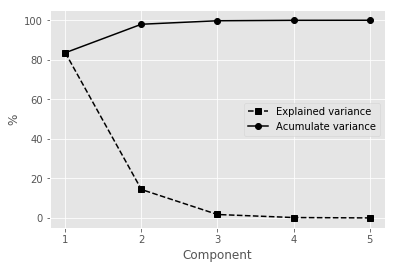

In [13]:
#### plotting ####
fig, ax = plt.subplots()

ax.plot(pca.explained_variance_ratio_ * 100, '--sk', label="Explained variance")
ax.plot(np.cumsum(pca.explained_variance_ratio_ * 100), '-ok', label="Acumulate variance")
ax.legend()
ax.set_xticks((0,1,2,3,4));
ax.set_xticklabels((1,2,3,4,5));
ax.set_xlabel('Component');
ax.set_ylabel('%');

In [14]:
# removing outliers from the data set
new_data = selected_spectra.drop(outliers, axis=0)
new_carbon = carbon_data.drop(outliers, axis=0)


## 4. Cross validation

### 4.1 Selecting the optimal number of latent variables

CPU times: user 3.25 s, sys: 7.05 s, total: 10.3 s
Wall time: 2.85 s


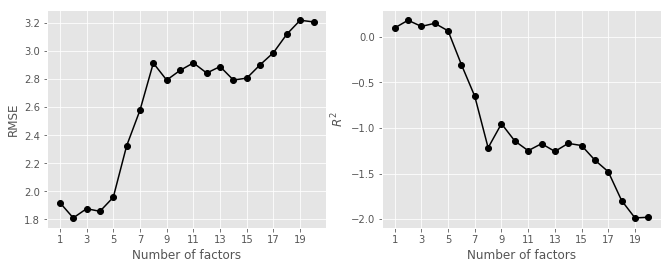

In [15]:
%%time
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error


kf = KFold(n_splits=5, shuffle=False)

mse = []
r2 = []
for i in range(1, 21):
    pls = PLSRegression(n_components=i, scale=False)
    score = cross_val_score(pls, new_data, new_carbon.C, cv=kf, scoring='neg_mean_squared_error').mean()
    score2 = cross_val_score(pls, new_data, new_carbon.C, cv=kf, scoring='r2').mean()
    mse.append(-score)
    r2.append(score2)

rmse = np.sqrt(mse)

fig, (ax0, ax1)  = plt.subplots(1, 2, figsize=(11, 4))
ax0.plot(rmse, '-ok');
ax0.set_xticks(range(0, 20, 2))
ax0.set_xticklabels(range(1, 21, 2))
ax0.set_xlabel("Number of factors");
ax0.set_ylabel("RMSE");
ax1.plot(r2, '-ok')
ax1.set_xticks(range(0, 20, 2))
ax1.set_xticklabels(range(1, 21, 2))
ax1.set_xlabel("Number of factors");
ax1.set_ylabel("$R^{2}$");
#fig.savefig('factors.svg')

In [16]:
factors = 2  # equivalent to latent variables

### 4.2 Selecting the best training/test sets

            0
280  0.824261


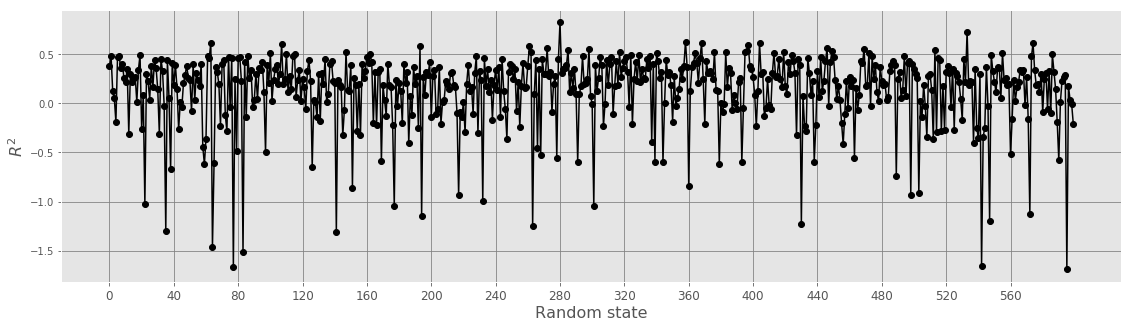

In [17]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error


r2 = []
for i in range(600):
    X_train, X_test , y_train, y_test = train_test_split(new_data, new_carbon.C, test_size=0.2, random_state=i)
    pls1 = PLSRegression(n_components=factors, scale=False)
    pls1.fit(X_train, y_train)
    y_pred = pls1.predict(X_test)
    r2.append(r2_score(y_test, y_pred))

r2 = pd.DataFrame(r2)
r2.index = range(600)
fig, ax = plt.subplots(figsize=(19,5))
ax.plot(r2, '-ok');
#ax.title("Split data 80-20%")
ax.set_xticks(range(0, 600, 40));
ax.set_xticklabels(range(0, 600, 40), fontsize=12)
ax.grid(color='gray');
ax.set_xlabel('Random state', fontsize=16);
ax.set_ylabel(r'$R^{2}$', fontsize=16);
#fig.savefig('random.svg')
print(r2.sort_values(by=[0], ascending=False).head(1))

In the previous plot, you need to  identify the random_state parameter that produced the highest R squared and use it in the next line.

(54, 525)


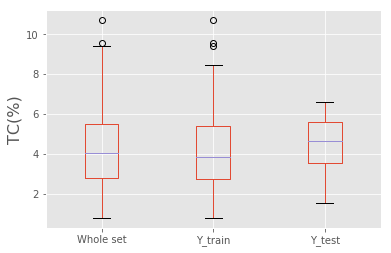

In [18]:
 X_train, X_test , y_train, y_test = train_test_split(new_data, 
                                                          new_carbon.C, test_size=0.2, 
                                                          random_state=280)

temp_dataframe = pd.concat([carbon_data.C, y_train, y_test], axis=1)
temp_dataframe.columns = ['Whole set', 'Y_train', 'Y_test']
ax = temp_dataframe.boxplot();
ax.set_ylabel('TC(%)', fontsize=16);
print(X_train.shape)

## 5. Final model calibration

In [19]:
pls = PLSRegression(n_components=factors, scale=False)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)

###### quality estimators ##########

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rpd = np.std(y_test)/rmse

print('r2 =', r2_score(y_test, y_pred))
print('RMSE =', rmse)
print('RPD=', rpd )

r2 = 0.824261077785
RMSE = 0.607402703591
RPD= 2.38542639632


### 5.1 Comparing measured and predicted values

R squared 0.824261077785
r value 0.915298957905
p_value 4.43263599007e-06
standard deviation 0.138064127748
slope= 1.08685543491 intercept= -0.527525495382


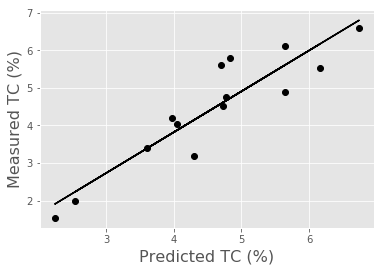

In [20]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(y_pred[:, 0], y_test)

print('R squared',r2_score(y_test, y_pred) )
print('r value', r_value)
print('p_value', p_value)
print('standard deviation', std_err)
print('slope=', slope, 'intercept=', intercept)

line = slope*y_pred[:, 0]+intercept
plt.plot(y_pred[:, 0],line,'-k',y_pred[:, 0], y_test,'ok');
plt.ticklabel_format(fontsize=16)
#plt.title("C Predicted vs C");
plt.xlabel("Predicted TC (%)", fontsize=16);
plt.ylabel("Measured TC (%)", fontsize=16);

#plt.savefig('lregression.svg')

## Comparing the mean of the smoothed spectra

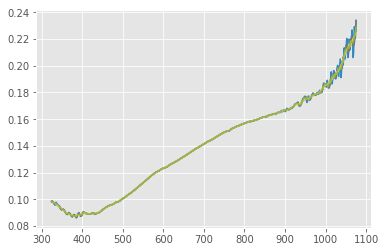

In [21]:
mean_1 = filtered_spectra1.mean(axis=0)
mean_2 = filtered_spectra2.mean(axis=0)
mean_3 = filtered_spectra5.mean(axis=0)
mean_4 = filtered_spectra6.mean(axis=0)
mean_5 = filtered_spectra9.mean(axis=0)
mean_6 = filtered_spectra10.mean(axis=0)

all_means = [mean_1, mean_2, mean_3, mean_4, mean_5, mean_6] 
fig, ax = plt.subplots()

for i in all_means:
    ax.plot(i)
